<a href="https://colab.research.google.com/github/laaksonenl/machine-learning/blob/master/red_wine_quality_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Red wine quality classification

In [1]:
! pip install -q kaggle
from google.colab import files

files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download -d 'uciml/red-wine-quality-cortez-et-al-2009'

Saving kaggle.json to kaggle.json
  0% 0.00/25.6k [00:00<?, ?B/s]
100% 25.6k/25.6k [00:00<00:00, 46.2MB/s]


In [2]:
%%bash
mkdir -p /content/data
unzip /content/red-wine-quality-cortez-et-al-2009.zip -d /content/data/

Archive:  /content/red-wine-quality-cortez-et-al-2009.zip
  inflating: /content/data/winequality-red.csv  


In [3]:
import pandas as pd

data = pd.read_csv('/content/data/winequality-red.csv')

In [4]:
data.shape

(1599, 12)

In [5]:
from sklearn.model_selection import train_test_split

X = data.drop("quality", axis=1)
y = data["quality"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

## Data exploration

In [6]:
X_train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
1210,6.8,0.65,0.02,2.1,0.078,8.0,15.0,0.99498,3.35,0.62,10.4
285,9.9,0.59,0.07,3.4,0.102,32.0,71.0,1.00015,3.31,0.71,9.8
1469,7.3,0.98,0.05,2.1,0.061,20.0,49.0,0.99705,3.31,0.55,9.7
927,8.4,0.67,0.19,2.2,0.093,11.0,75.0,0.99736,3.20,0.59,9.2
961,7.1,0.56,0.14,1.6,0.078,7.0,18.0,0.99592,3.27,0.62,9.3


In [7]:
X_train.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000
mean,8.285066,0.530457,0.269054,2.547615,0.086842,15.911259,46.319781,0.996738,3.314660,0.659070,10.427704
std,1.730230,0.180984,0.192459,1.460699,0.046211,10.395078,32.338944,0.001911,0.154011,0.171979,1.065496
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.860000,0.330000,8.400000
25%,7.100000,0.400000,0.095000,1.900000,0.070000,8.000000,22.000000,0.995575,3.210000,0.550000,9.500000
50%,7.900000,0.520000,0.250000,2.200000,0.079000,14.000000,38.000000,0.996720,3.310000,0.620000,10.200000
75%,9.200000,0.640000,0.420000,2.600000,0.089000,21.000000,61.000000,0.997860,3.400000,0.730000,11.100000
max,15.600000,1.580000,0.790000,15.500000,0.611000,72.000000,278.000000,1.003690,4.010000,1.980000,14.000000


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


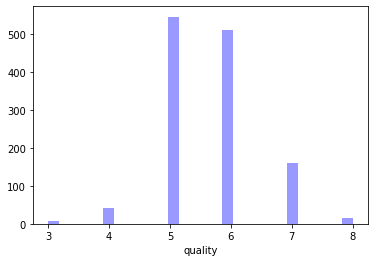

In [8]:
import seaborn as sns

sns.distplot(y_train, kde=False, color='blue')


In [9]:
y_train.value_counts()

5    545
6    510
7    159
4     42
8     15
3      8
Name: quality, dtype: int64

In [10]:
combined = pd.concat([X_train, y_train], axis=1)

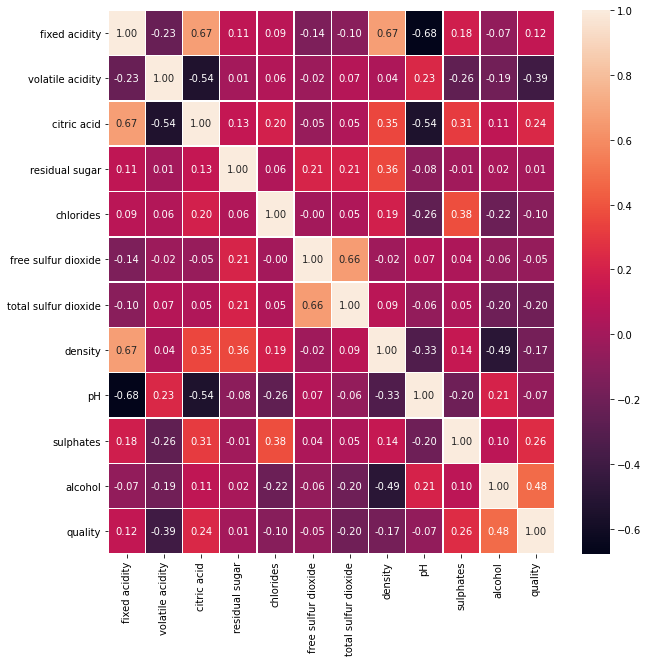

In [11]:
import matplotlib.pyplot as plt

figure, axes = plt.subplots(figsize = (10,10))

sns.heatmap(combined.corr(), annot = True, linewidths=.5, fmt = ".2f", ax=axes)
plt.show()

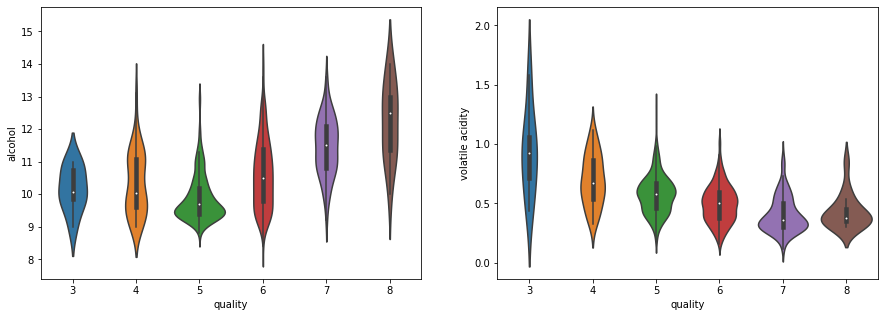

In [12]:
fig, axes = plt.subplots(1, 2, figsize =(15,5))

def violin(feature, ax):
  sns.violinplot(x='quality',
                 y=feature,
                 sizes=(10, 200),
                 data=combined,
                 ax=ax)

violin('alcohol', axes[0])
violin('volatile acidity', axes[1])

Since standard coefficient correlation captures only linear correlations, plot the pairs to detect nonlinear correlations.


In [13]:
combined['quality'].value_counts()

5    545
6    510
7    159
4     42
8     15
3      8
Name: quality, dtype: int64

In [14]:
x = combined.groupby(pd.cut(combined['quality'], bins=[1, 3, 7, 10]))
bin_keys = x.groups.keys()
labels = { 1: 'Bad', 2: 'Mediocre', 3: 'Good' }

tmp = combined.copy()
for i, b in enumerate(bin_keys, 1):
  idx = x.groups.get(b)
  tmp.loc[idx, 'quality'] = labels[i]

tmp.head()
tmp['quality'].value_counts()

Mediocre    1256
Good          15
Bad            8
Name: quality, dtype: int64

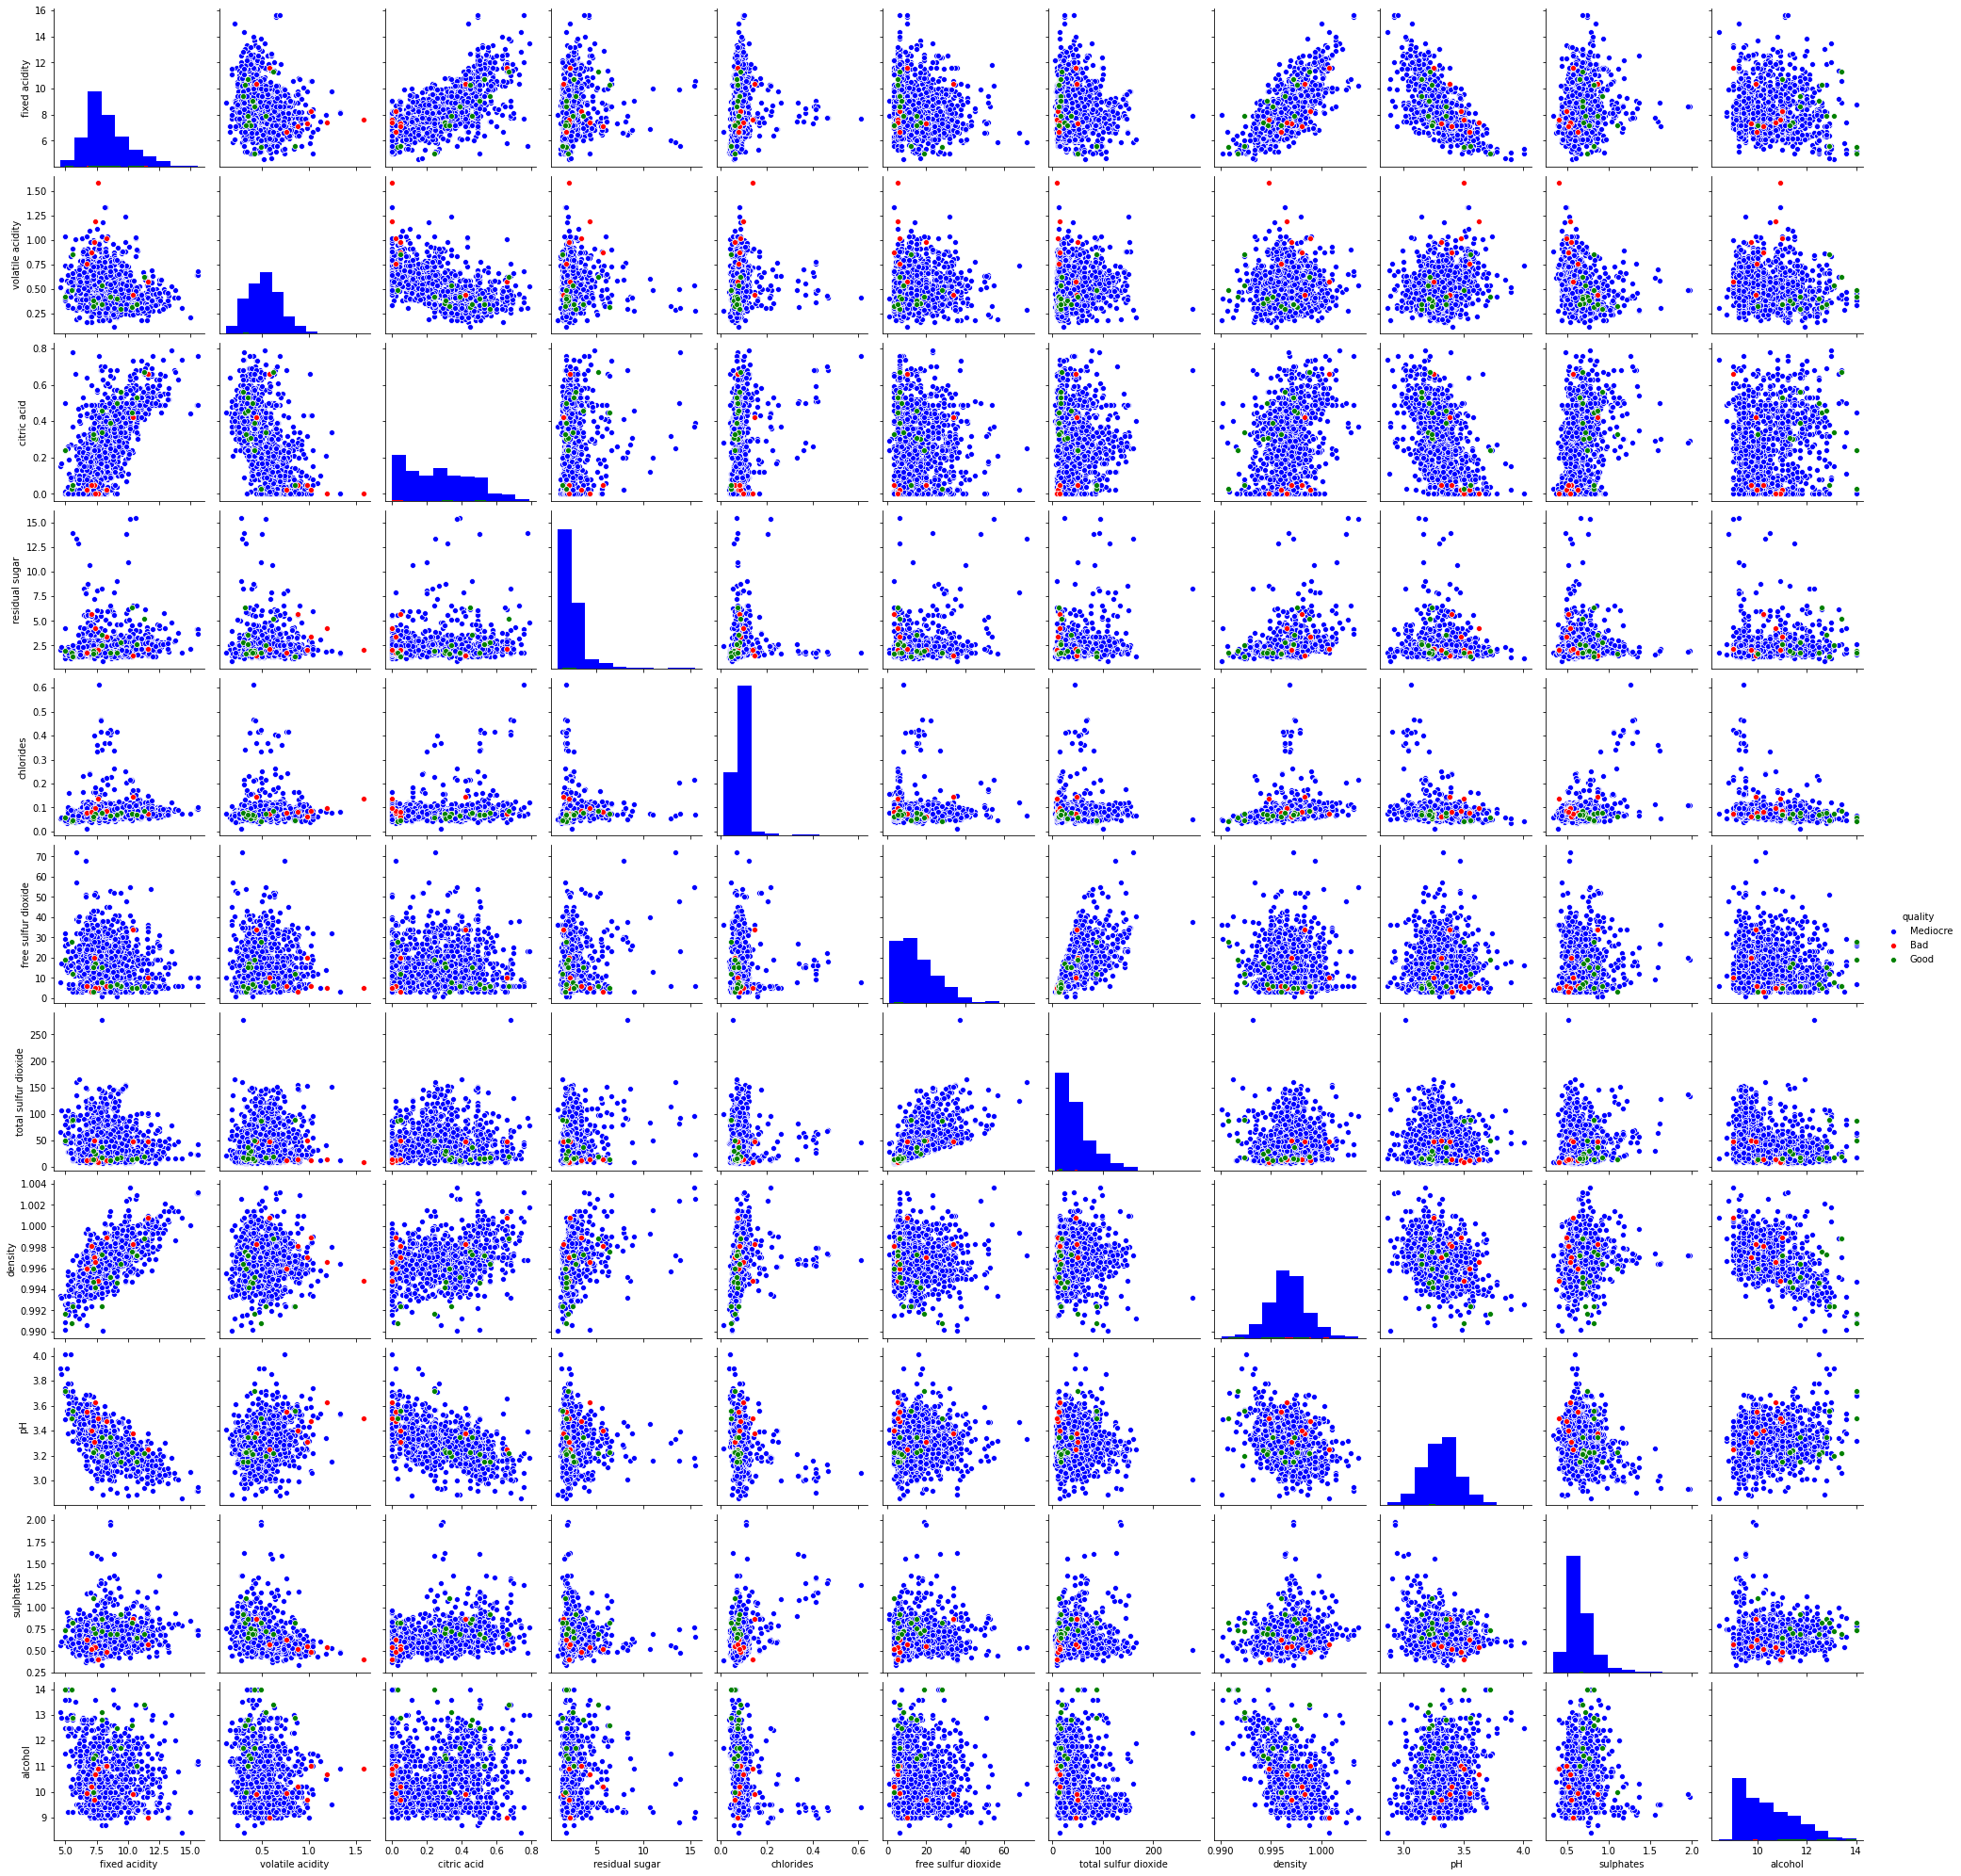

In [15]:
sns.pairplot(tmp, hue='quality', diag_kind='hist', palette={'Bad': 'red', 'Mediocre': 'blue', 'Good': 'green'})

In [32]:

def apply_classification(name_clf, clf, x_train, x_test, y_train, y_test):
    grid_clf = grid_search(name_clf, clf, x_train, x_test, y_train, y_test)
    
    #Plotting the learning curve
    # score curves, each time with 30% data randomly selected as a validation set.
    cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=42)
    plot_learning_curve(grid_clf, name_clf, x_train, y_train, 
                    ylim=(0.1, 1.01), cv=cv, n_jobs=4)
    
    #Apply cross validation to estimate the skills of models with 10 split with using best parameters
    # scores = cross_val_score(grid_clf, x_train, y_train, cv=10)
    # print("Mean Accuracy of Cross Validation: %", round(scores.mean()*100,2))
    # print("Std of Accuracy of Cross Validation: %", round(scores.std()*100))
    # print("------------------------------------------")
    
    #Predict the test data as selected classifier
    # clf_prediction = grid_clf.predict(x_test)
    # clf1_accuracy = sum(y_test == clf_prediction)/len(y_test)
    # print("Accuracy of",name_clf,":",clf1_accuracy*100)
    
    # #print confusion matrix and accuracy score before best parameters
    # clf1_conf_matrix = confusion_matrix(y_test, clf_prediction)
    # print("Confusion matrix of",name_clf,":\n", clf1_conf_matrix)
    # print("==========================================")
    # return grid_clf

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000
mean,8.285066,0.530457,0.269054,2.547615,0.086842,15.911259,46.319781,0.996738,3.314660,0.659070,10.427704
std,1.730230,0.180984,0.192459,1.460699,0.046211,10.395078,32.338944,0.001911,0.154011,0.171979,1.065496
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.860000,0.330000,8.400000
25%,7.100000,0.400000,0.095000,1.900000,0.070000,8.000000,22.000000,0.995575,3.210000,0.550000,9.500000
50%,7.900000,0.520000,0.250000,2.200000,0.079000,14.000000,38.000000,0.996720,3.310000,0.620000,10.200000
75%,9.200000,0.640000,0.420000,2.600000,0.089000,21.000000,61.000000,0.997860,3.400000,0.730000,11.100000
max,15.600000,1.580000,0.790000,15.500000,0.611000,72.000000,278.000000,1.003690,4.010000,1.980000,14.000000


In [82]:
from sklearn.model_selection import learning_curve
import numpy as np

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)

    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, 
                                                            n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")

    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
                     
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    
    return plt

In [52]:
from sklearn.model_selection import GridSearchCV

def log_reg_gridsearch(pipe, X_train, y_train):
  log_reg_params = { 'LogReg__penalty': ['l1', 'l2'], 'LogReg__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
  grid_log_reg = GridSearchCV(pipe, log_reg_params)
  grid_log_reg.fit(X_train, y_train)

  log_reg = grid_log_reg.best_estimator_
  print("Best parameters: ", grid_log_reg.best_estimator_)
  print("Best Score for Logistic Regression: ", grid_log_reg.best_score_)
  return log_reg

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

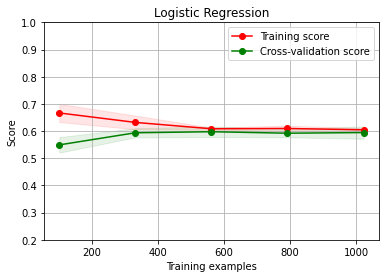

In [81]:
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

plot_learning_curve(logreg, 'Logistic Regression', X_train, y_train, ylim=(0.2, 1.0), cv=sss)


## Models

Models to try:

1. Logistic regression

In [55]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([
    ('Scaler', StandardScaler()),
    ('LogReg', LogisticRegression(max_iter=10000))
  ])

In [59]:
import warnings
warnings.filterwarnings('ignore')

logreg = log_reg_gridsearch(logreg, X_train, y_train)

Best parameters:  Pipeline(memory=None,
         steps=[('Scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('LogReg',
                 LogisticRegression(C=1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=10000,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)
Best Score for Logistic Regression:  0.6012132352941176


In [57]:
logreg.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('Scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('LogReg',
                 LogisticRegression(C=1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=10000,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [60]:
from sklearn import metrics

def print_report(pipe, data, labels):
    y_pred = pipe.predict(data)
    report = metrics.classification_report(labels, y_pred, zero_division=0)
    print(report)
    print("Accuracy: {:0.3f}".format(metrics.accuracy_score(labels, y_pred)))
  
print_report(logreg, X_train, y_train)

              precision    recall  f1-score   support

           3       0.33      0.12      0.18         8
           4       0.67      0.05      0.09        42
           5       0.67      0.76      0.71       545
           6       0.56      0.60      0.58       510
           7       0.53      0.34      0.42       159
           8       0.00      0.00      0.00        15

    accuracy                           0.61      1279
   macro avg       0.46      0.31      0.33      1279
weighted avg       0.60      0.61      0.59      1279

Accuracy: 0.608
